## Примечание к проекту:
Данный проект был выполнен в "ГуглКолаборатория" с окружением Я.Практикума. С помощью этой [статьи](https://www.bizkit.ru/2021/01/03/18852/) попробовал соединить две необходимые для Практикума вещи в одно целое. Посмотрим, что получится в итоге.

UPD: оказалось, что это слишком времязатратная процедура (необходимо постоянно создавать токен для доступа к локальной среде выполнения). Придумаю что-нибудь другое...

---

# Описание проекта

Необходимо выявить определяющие успешность игры закономерности. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

---

# Содержание проекта
1. [Знакомство с данными](#1)
2. [Предобработка данных](#2)
  * [Замена названий столбцов](#2_1)
  * [Обработка пропусков](#2_2)
  * [Преобразование типов данных](#2_3)
  * [Вывод по разделу](#2_4)
3. [Исследовательская часть](#3)
  * [Сколько игр выпускалось в разные годы](#3_1)
  * [Как менялись продажи по платформам](#3_2)
  * [Динамика платформ за актуальный период](#3_3)
  * [Анализ глобальных продаж](#3_4)
  * [Исследование влияния отзывов критиков и игроков на продажи](#3_5)
  * [Распределение игр по жанрам](#3_6)
4. [Портрет пользователя каждого региона](#4)
  * [Самые популярные платформы](#4_1)
  * [Какие жанры популярны](#4_2)
  * [Как рейтинг ESRB влияет на продажи](#4_3)
5. [Проверка гипотез](#5)
6. [Общий вывод](#6)

# Знакомство с данными <a id="1"></a>

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st

In [2]:
try:
  df = pd.read_csv('drive/MyDrive/datasets/games.csv')
except:
  df = pd.read_csv('/datasets/games.csv')

Прежде всего ознакомимся с данными. Выберем 5 случайных наблюдений и посмотрим на них.

In [3]:
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
4154,Victorious Boxers: Ippo's Road to Glory,PS2,2000.0,Fighting,0.05,0.04,0.38,0.01,75.0,8,T
11207,Jumper: Griffin's Story,Wii,2008.0,Action,0.08,0.00,0.00,0.01,28.0,2.5,T
9250,Fear Factor: Unleashed,GBA,2004.0,Action,0.10,0.04,0.00,0.00,30.0,3,T
7343,TRON: Evolution - Battle Grids,Wii,2010.0,Racing,0.17,0.02,0.00,0.01,NaN,NaN,NaN
13977,Meteos: Disney Magic,DS,2007.0,Puzzle,0.01,0.02,0.00,0.00,74.0,6.6,E


## Описание данных

*   `Name` - название игры;
*   `Platform` - платформа;
*   `Year_of_Release` - год выпуска;
*   `Genre` - жанр игры;
*   `NA_sales` - продажи в Северной Америке (миллионы проданных копий);
*   `EU_sales` - продажи в Европе (миллионы проданных копий);
*   `JP_sales` - продажи в Японии (миллионы проданных копий);
*   `Other_sales` - продажи в других странах (миллионы проданных копий);
*   `Critic_Score` - оценка критиков (максимум 100);
*   `User_Score` - оценка пользователей (максимум 10);
*   `Raiting` - рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

После того, как увидели, что из себя представляют признаки, познакомимся с общей информации о таблице.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Вывод

В процессе знакомства с данными выявили следующее:

1. В столбцах нашей таблицы все наименования имеют верхний регистр, что в дальнейшем может затруднить работу с этими признаками;
2. В таблице имеются явные пропуски;
3. Дополнительная информация дает полное представление о содержащейся в ней информации.
4. Некорректный тип данных. Например, столбец `year_of_release` представлен тип с плавающей точкой, `user_score` представлен строковым типом несмотря на то, что в случайно выбранных строках представлены данные в числовом формате.

Таким образом, необходимо провести предобработку данных:

1. Приведение наименование признаков к нижнему регистру;
2. Определить причину возникновения пропусков и выбрать наиболее выгодный способ устранить их;
3. Определить наличие неявных пропусков и разобраться в причине их возникновения;
4. Привести некоторые столбцы к корректым типам данных.

# Предобработка данных <a id="2"></a>

-------

## Замена названий столбцов <a id="2_1"></a>

Для начала заменим названия столбцов (приведем их к нижнему регистру).

In [5]:
df.columns = df.columns.str.lower()

Проверим, заменились ли наименования столбцов 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Столбцы приведены к нижнему регистру. Теперь рассмотрим на явные и неявные пропуски в данных для дальнейшего преобразования данных.

## Обработка пропусков <a id="2_2"></a>

Для начала посмотрим в каких признакаха у нас имеются пропуски и к какому типу переменной относится признак:

*   `name` - категориальная; [x]
*   `year_of_release` - категориальная;
*   `genre` - категориальная; [x]
*   `critic_score` - категориальная;
*   `user_score` - категориальная;
*   `raiting` - категориальная;

Посчитаем долю явных пропусков в таблице:

In [7]:
df.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

In [8]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Видим, что у нас есть наблюдения, доля пропусков в которых меньше десятой доли процента. Это столбцы `name` и `genre`. Посмотрим на наблюдения, где имеются пропуски по этим признакам одновременно.

In [9]:
df[(df.name.isna() == True) & (df.genre.isna() == True)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Видим, что эти пропуски одновременно присутствуют. Более того, данные пропуски можно отнести к мусору или систематической ошибкой, так как данные, необходимые для анализа нельзя восстановить. А удалив десятую долю процента мы не исказим значительно результаты исследования. 

Поэтому удалим эти пропуски.

In [10]:
df = df.dropna(subset = ['name', 'genre'])

Удостоверимся, что у нас пропуски удалены.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Незначительные пропуски удалены, можно идти дальше. 

Теперь рассмотрим `year_of_release`.

In [12]:
df[df.year_of_release.isna() == True].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Всего 269 строк, что представляет собой ~1.7% от общей выборки. Такое количество существенно не исказит наши результаты исследований, поэтому удалим этим пропуски из таблицы.

In [13]:
df = df.dropna(subset = ['year_of_release'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Пропуски в столбце `year_of_release` удалены. Теперь посмотрим на оставшиеся пропуски в нашей таблице.

Рассмотрим столбец `critic_score`. Посмотрим на наблюдения, где есть пропуски в этой таблице и определим количество уникальных значений.

In [14]:
df[df.critic_score.isna() == True].sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6046,Sesame Street: Cookie's Counting Carnival,Wii,2010.0,Misc,0.27,0.00,0.00,0.02,NaN,tbd,EC
5450,Deathtrap Dungeon,PS,1998.0,Action,0.19,0.13,0.00,0.02,NaN,NaN,NaN
3462,Tales of Phantasia,PS,1998.0,Role-Playing,0.00,0.00,0.54,0.04,NaN,NaN,NaN
15563,Resident Evil 5 HD,XOne,2016.0,Action,0.02,0.00,0.00,0.00,NaN,NaN,NaN
11464,Slam 'n Jam '96 featuring Magic & Kareem,PS,1995.0,Sports,0.04,0.03,0.00,0.01,NaN,NaN,NaN
11411,Build 'n Race,Wii,2009.0,Racing,0.08,0.00,0.00,0.01,NaN,tbd,E
13044,Mr Bean's Wacky World of Wii,Wii,2009.0,Adventure,0.00,0.05,0.00,0.00,NaN,tbd,E
4834,Avatar: The Game,DS,2009.0,Action,0.18,0.18,0.00,0.04,NaN,NaN,NaN
13171,Dr. Seuss: Green Eggs and Ham,GBA,2003.0,Action,0.04,0.01,0.00,0.00,NaN,9,E
2970,Star Wars: Masters of Teras Kasi,PS,1997.0,Action,0.38,0.26,0.00,0.04,NaN,NaN,NaN


Видим, что у нас есть пропуски, как оценке критиков, так и в рейтинге, и оценке пользователей одновременно. Однако по пропускам можно заметить следующие причины возникновения пропусков:

1.   Пропуски в оценке игры связаны с тем, что игра продавалась исключительно в Японии. Это можно заметить по количеству продаж в столбцах `np_sales`, `eu_sales`, `jp_sales` и `other_sales`. Эти игры не продавались зарубежом и про них нет информации по оценкам;
2.   Игра не оценивалась, потому что это переиздание старой игры, например: `resident evil zero` на персональные компьютеры. Игра не изменена с точки зрения геймпея, нет дополнительного контента, только улучшение графики. Смысла еще раз оценивать ремейки нет - отсюда возможная причина пропуска;
3. Игры жанра `misc` - это аркады. Такие игры мало кто играет и оценки от критиков и игроков, соответсвенно, нет;
4. Игры, которые оказались малопопулярными у игроков и имеющие малое количество продаж - меньше 10 тысяч проданных копий. Такие игры прошли мимо игроков и критиков.
5. Дата выхода игры. Имеются пропуски в играх, которые вышли в 90ых, начале 2000ых годов. Информация об оценке игр могла не сохраниться.

Таким образом можно выявить общую тендецию к возникновению пропусков:

1. Малые продажи игр;
2. Выпуск игры в определенном регионе;
3. Малая популярность игры.
4. Год выпуска игры.

Таких пропусков в столбце представляет собой 52% от общей выборки. Посмотрим на количество уникальных значений в этом столбце.

In [15]:
df.critic_score.value_counts().head()

70.0    252
71.0    248
75.0    240
80.0    235
73.0    234
Name: critic_score, dtype: int64

Видим, что нестандартных значений, которыми могли заполнять пропуски нет. Таким образом можно предложить следующие варианты заполнения пропусков:

* заполнить пропуск нестадартным значением;
* оставить пропуски как есть, так как восстановить значения в этом столбце будет времязатратной процедурой.

Выбрали: **оставляем как есть**

Теперь посмотрим на `user_score`. Взглянем на общую информацию о таблице.

In [16]:
df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

Видим, что у нас столбец `user_score` представлен строковым форматом. Это кажется странным. Посомтрим на список уникальных значений и количество их упоминаний:

In [17]:
df.user_score.value_counts().head()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
Name: user_score, dtype: int64

У нас есть странное значение, которого очень много. Это `tbd`. Узнаем, что это такое с помощью сервиса [Metacritic](https://www.metacritic.com/faq#item13)
  > To help ensure that METASCORES accurately reflect the reviews given by critics for any particular movie, game, television show or album, we do not display a METASCORE for those items that do not have at least four (4) reviews in our database. Once this minimum number of reviews is reached, the METASCORE will display.

На основе сервиса оценки игры, кино и прочего можем понять что причина возникновения `tbd` связано с тем, что отзывов игроков и критиков меньше четырех, то есть можно предположить что это возникает в результате слишком малого количества отзывов или отсутствия отзывов вовсе. Слишком малое количество отзывов может быть связана с низкой популярностью игры, малыми продажами, годом выпуска игры. 

Таким образом, данное значение можем интерпретировать как пропуск. И заменим эти значения на пропуск.

In [18]:
df.loc[df.user_score == 'tbd', 'user_score'] = np.nan
df.user_score.value_counts().head()

7.8    322
8      285
8.2    276
8.3    252
7.5    249
Name: user_score, dtype: int64

Аббревиатура `tbd` заменена на пропуск. Приины возникновения пропусков в оценке игры от игроков предположительно идентична с пропусками в оценке игр от игроков:
1. Низкая популярность игры;
2. Год выпуска игры;
3. Выход игры в определенном регионе

Восстановить значение в этом столбце представляется невозможнымм. Поэтому оставим пропуски как есть.

Теперь рассмотрим столбец `rating` - рейтинг от орагнизации ESRB. Посмотрим на список уникальных значений и количество их упоминаний.

In [19]:
df.rating.value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

Не совсем ясно, что из себя представляют собой наименования рейтингов от ESRB. Ознакомимся с пояснением из [статьи](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board)
* **«EC» («Early childhood»)** — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры. Некоторые усложнённые развивающие игры могут иметь рейтинг «Everyone».
* **«E» («Everyone»)** — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера
* **«E10+» («Everyone 10 and older»)** — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. 
* **«T» («Teen»)** — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.
* **«M» («Mature»)** — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.
* **«AO» («Adults Only 18+»)** — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением.
* **«RP» («Rating Pending»)** — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу.

Видим, что у нас есть странный рейтинг **K-A** узнаем, что он означает. Для этого воспользуемся [источником](https://boardgamegeek.com/videogamerating/2220/esrb-k)
> K-A for Kids to Adults: Games that contain content that is suitable for a general audience. This rating was used until the year 1998 when it renamed to E.

Из описания рейтинга видим, что он просуществовал до 1998 года, а затем его переименовали в E (Everyone)

Посмотрим на игры с таким наблюдением и заменим наименование рейтинга на `E`

In [20]:
df[df.rating == 'K-A']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
656,Theme Hospital,PC,1997.0,Strategy,2.30,0.10,0.00,0.00,NaN,9,K-A
903,PaRappa The Rapper,PS,1996.0,Misc,0.26,0.16,1.46,0.03,92.0,7.4,K-A
16681,Worms 2,PC,1997.0,Strategy,0.00,0.01,0.00,0.00,NaN,8.1,K-A


Потверждения подтвердились. Все игры с этим рейтингом выходили ранее 1998 года. Для простоты добавим эти игры в группу E

In [21]:
df.loc[df.rating == 'K-A', 'rating'] = 'E'
df.rating.value_counts()

E       3924
T       2905
M       1536
E10+    1393
EC         8
RP         1
AO         1
Name: rating, dtype: int64

Однако у нас есть одно наблюдение, рейтинг который представлен RP. Посмотрим, что это за игра.

In [22]:
df[df.rating == 'RP']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14270,Supreme Ruler: Cold War,PC,2011.0,Strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP


У нас есть одна игра с рейтингом RB несмотря на то, что эта игра вышла в 2011 году. Посмотрим на сайте [ESRB](https://www.esrb.org/ratings/31253/Supreme+Ruler+Cold+War/tps), действительно ли рейтинг данной игры сейчас в статусе RP. 

Оказалось, что игра сейчас имеет рейтинг E10+. Видимо, выгрузка игр в базу данных проводится ежегодно или это систематическая ошибка. Добавим игру в рейтинг E10+

In [23]:
df.loc[df.rating == 'RP', 'rating'] = 'E10+'
df.rating.value_counts()

E       3924
T       2905
M       1536
E10+    1394
EC         8
AO         1
Name: rating, dtype: int64

Аномальные значения в этом столбце устранены. Теперь посмотрим на данных, где у нас есть пропуск в этом столбце:

In [24]:
df[df.rating.isna() == True].sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15286,Triple Crown Championship Snowboarding,Wii,2010.0,Sports,0.02,0.00,0.00,0.00,NaN,NaN,NaN
10278,Picross 3D 2,3DS,2015.0,Puzzle,0.00,0.00,0.11,0.00,NaN,NaN,NaN
15277,Diabolik Lovers: More Blood,PSV,2015.0,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
12740,Monkey Island: Special Edition Collection,X360,2011.0,Adventure,0.00,0.05,0.00,0.01,NaN,NaN,NaN
5734,Tiny Toon Adventures: The Great Beanstalk,PS,1998.0,Misc,0.17,0.12,0.00,0.02,NaN,NaN,NaN
1469,Spider-Man: The Movie,GBA,2002.0,Action,0.92,0.35,0.01,0.05,NaN,NaN,NaN
12853,Tokyo Mono Harashi: Karasu no Mori Gakuen Kitan,PSP,2010.0,Role-Playing,0.00,0.00,0.06,0.00,NaN,NaN,NaN
30,Pokémon Yellow: Special Pikachu Edition,GB,1998.0,Role-Playing,5.89,5.04,3.12,0.59,NaN,NaN,NaN
8666,Halo Triple Pack,XB,2005.0,Shooter,0.12,0.03,0.00,0.01,NaN,NaN,NaN
15250,Lode Runner,DS,2006.0,Puzzle,0.00,0.00,0.02,0.00,NaN,NaN,NaN


А теперь ознакомимся с тем, как присуждают рейтинг игре ассоциация ESRB:
> На веб-сайте ESRB сообщается, что затем рецензенты независимо оценивают продукт и определяют рейтинг. Оценкой рейтинга занимаются многие люди разных возрастов и слоёв общества. Это могут быть бывшие школьные учителя, родители, профессионалы и различные работники из других сфер деятельности, не связанные с игровой индустрией. Если рецензенты сходятся в оценке, то к рейтингу добавляют краткие описания и ESRB уведомляет издателя о своём решении.
Когда игра готова к продаже, издатель отправляет копии финальной версии в ESRB. Подвергается осмотру упаковка игры, а предоставленные издателем сведения о содержании игры обычно проверяются путём её тестирования. Если игра оказывается более жёсткой, чем было представлено в видеоролике, или покупатели высказываются о несоответствии рейтинга и содержимого продукта, к издателю могут быть применены различные санкции.

Видим, что у нас есть большое количество пропусков. Однако стоит отметить один нюанс: ESRB - это организация, которая присваивает рейтинг играм для США, Канады и Мексики. Помимо ESRB существуют и другие рейтинги оценки контента, которые имеют юридическую силу в других регионах (PEGI - для Европы, например). 

Поэтому одна из причин возникновения пропуска может быть связана с тем, что игра могла не продаваться в США, Канаде и Мексике и поэтому игра не получила региаональный рейтинг. 
Более того, причина пропуска может быть связана с проблемой выгрузки информации в базу данных.

Восстанавливать рейтинг для каждой игры на освновании текущего состояния это времязатратная процедура, удалять наблюдения по этим пропускам тоже нельзя - потеряем большое количество данных.

Поэтому оствим пропуск как есть.

## Вывод

В процессе обработки пропусков были обнаружены пропуски в нескольких столбцах нашей таблицы. Изучили причины появления этих пропусков и установили предполагаемые причины:
1. Систематическая ошибка при сборе данных;
2. Низкая популярность игры;
3. Специфика продажи игры по регионам: какие-то игры продавались исключительно в Японии
Некотоорые пропуски были удалены, а некоторые проигнорированы в целях сохранения данных.

|Признак|Обработка пропуска|
|:------|:-----------------|
|`name`|**удалены наблюдения**|
|`genre`|**удалены наблюдения**|
|`year_of_release`|**удалены наблюдения**|
|`critic_score`|**оставим как есть**|
|`user_score`|**оставим как есть**. Некоторые значениям представили как пропуск|
|`rating`|**оставим как есть**. Некоторые значения присоединили к другим группам данных|

После обработки данных перейдем к преобразованию типов данных.

## Преобразование типов данных <a id="2_3"></a>

Прежде всего рассмотрим столбцы, в которых необходимо преобразовать данные к соотвествующему типу:

*   `year_of_release` - привести к типу данных `datetime`
*   `user_score` - привести к типу данных `float`

Начнем с `year_of_release`. Приведем  этот столбец к формату `datetime` и выберем год. Проверим, как у нас получилось:


In [25]:
df.year_of_release = pd.to_datetime(df.year_of_release, format = '%Y').dt.year
df.dtypes

name                object
platform            object
year_of_release      int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

In [26]:
df.sample()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11148,The Mummy: Tomb of the Dragon Emperor,DS,2008,Action,0.08,0.0,0.0,0.01,43.0,NaN,T


Изменили тип данных в столбце `year_of_release`. Теперь перейдем к столбцу `user_score`.

In [27]:
df.user_score = pd.to_numeric(df.user_score, errors = 'coerce')
df.dtypes

name                object
platform            object
year_of_release      int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

In [28]:
df.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E


Данные имеют корректный тип данных.

## Вывод по разделу <a id="2_4"></a>

В результате предобработки данных обнаружили следующие проблемы:

|Проблемы в данных|Решение проблемы|
|:---------------:|:--------------:|
|**Названия столбцов имеют нижний регистр**|**Наименования столбцов приведены к нижнему регистру**|
|**Пропуски в данных**|**Применили: фильтрацию, игнорирование пропусков; некоторые значения сгруппировали к большим группам**|
|**Некорректные типы данных**|**Столбцы с некорректным типом данных привели к соответствующему типу**|

После того, как предобработали данные, приступим к исследовательской части проекта.

Прежде чем начнем проводить исследование данных посчитаем суммарные продажи во всех регионах.

In [29]:
df['total_sales'] = df.na_sales + df.eu_sales + df.jp_sales + df.other_sales
df.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54


# Исследовательская часть <a id="3"></a>

---

## Сколько игр выпускалось в разные годы <a id="3_1"></a>

Сперва построим график, который покажет, как много игр выпускалось в разные годы. А заьем определим, действительно ли все года необходимы для проведения анализа.

In [30]:
def create_bar(groupby_col : str, func : str, y = 'name'):
  df_to_plot = df.groupby(groupby_col)[y]
  if func == 'count':
    df_to_plot_calculate = df_to_plot.count()
    figsize = (20, 10)
    df_to_plot_calculate.plot(kind = 'bar', y = y, figsize = figsize, edgecolor = 'black', grid = True)
    plt.title('Количество игр растет с каждым годом')
  elif func ==  'sum':
    df_to_plot_calculate = df_to_plot.sum().sort_values()
    figsize = (20, 10)
    df_to_plot_calculate.plot(kind = 'barh', y = y, figsize = figsize, edgecolor = 'black')
    plt.title('Количество продаж по платформам (млн. копий)')

In [31]:
#create_bar('year_of_release', 'count')

Видим, что до 1991 года игр выпускалось не так много. Затем с каждым годом наблюдается рост выпуска игр, пик которого находится в диапазоне с 2002  по 2009 год. Затем наблюдается резкий спад игр. 
Такой большой выпуск игр связан с тем, что начинают появляются основные консоли, которые имели большую популярность PS2, XBOX, XBOX360, PS3, WII, 3DS. Однако спад с 2010 года связан с падением интереса людей к играм и постепенный переход к мобильному геймингу.

Предварительно можно сказать, что значимым периодом для нашего анализа будет период с 2002-2016 год.

In [32]:
def create_bar(groupby_col : str, func : str, y = 'name'):
  df_to_plot = df.groupby(groupby_col)[y]
  if func == 'count':
    df_to_plot_calculate = df_to_plot.count()
    figsize = (20, 10)
    df_to_plot_calculate.plot(kind = 'bar', y = y, figsize = figsize, edgecolor = 'black', grid = True)
    plt.title('Количество игр растет с каждым годом', fontsize = 15)
    plt.xlabel('Год выпуска', fontsize = 15)
    plt.ylabel('Количество выпущенных игр', fontsize = 15)
    plt.xticks(fontsize = 15)
  elif func ==  'sum':
    df_to_plot_calculate = df_to_plot.sum().sort_values()
    figsize = (20, 10)
    df_to_plot_calculate.plot(kind = 'barh', y = y, figsize = figsize, edgecolor = 'black')
    plt.title('Количество продаж по платформам (млн. копий)', fontsize = 15)
    plt.ylabel('Платформа', fontsize = 15)
    plt.xlabel('Количество продаж (млн. копий)', fontsize = 15)

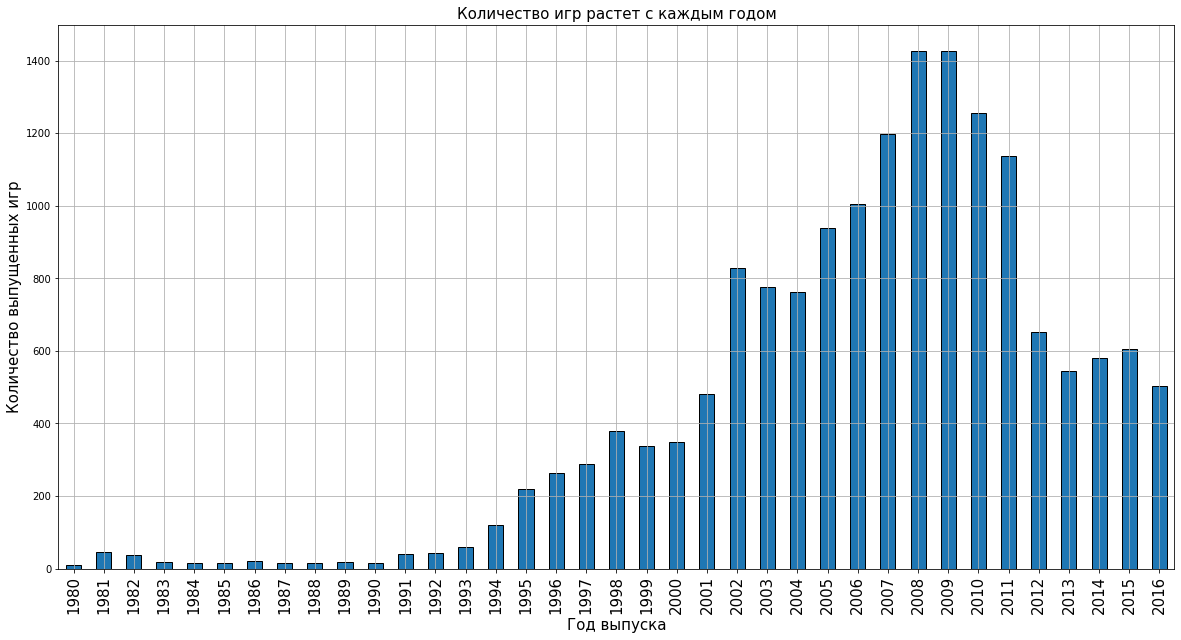

In [33]:
create_bar('year_of_release', 'count')

## Как менялись продажи по платформам <a id="3_2"></a>


Прежде всего посмотрим, какие платформы больше всего имели продаж за все время

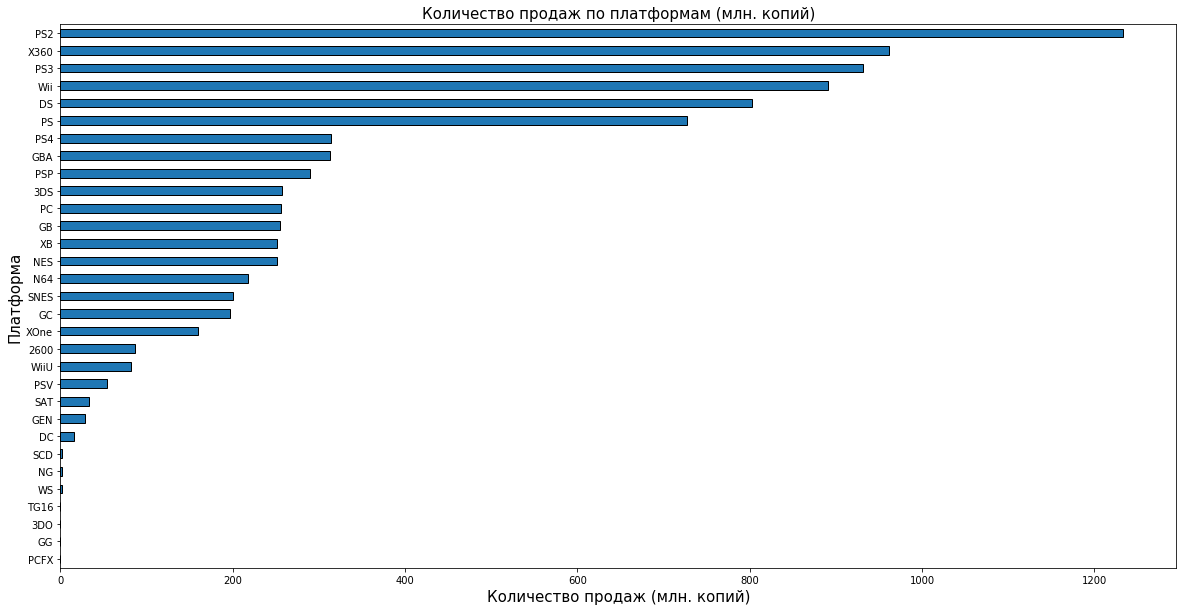

In [34]:
create_bar('platform', 'sum', 'total_sales')

Видим, что у нас есть топ-6 лидеров продаж, выведем наименования этих топ платформ по продажам.

In [36]:
df.groupby('platform')['total_sales'].sum().sort_values(ascending = False)[:6]

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
Name: total_sales, dtype: float64

На момент 2016-го года получили список платформ, игры для которых продавались больше всего:
1. Playstation 2;
2. XBOX 360;
3. Playstation 3;
4. Nintendo Wii;
5. Nintendo DS;
6. Playstation.

Сформируем список из этих топовых платформ и построим график, который покажется, как менялось популярность платформ по годам.

In [37]:
top_platform = pd.Series(df.groupby('platform')['total_sales'].sum().sort_values(ascending = False)[:6]).index.tolist()

In [38]:
top_platform

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

Затем построим график зависимости продаж игр каждой плафтормы по каждому году

In [39]:
df_top_platform = df.query('platform in @top_platform')

In [40]:
df_top_platform.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


In [41]:
def draw_lines(df: pd.DataFrame, column : str, title = 'Продолжительность жизни плафторм'):
  draw_plot = df.pivot_table(
      index = column,
      columns = 'platform',
      values = 'name',
      aggfunc = 'count'
  ). plot(
      kind = 'line',
      style = 'o-',
      figsize = (20,10),
      title = title
  )
  plt.grid()
  plt.title(title, fontsize = 15)
  plt.xlabel('Год выпуска', fontsize = 15)
  plt.ylabel('Количество выпущенных игр', fontsize = 15)
  plt.legend(loc=0, prop={'size': 12})

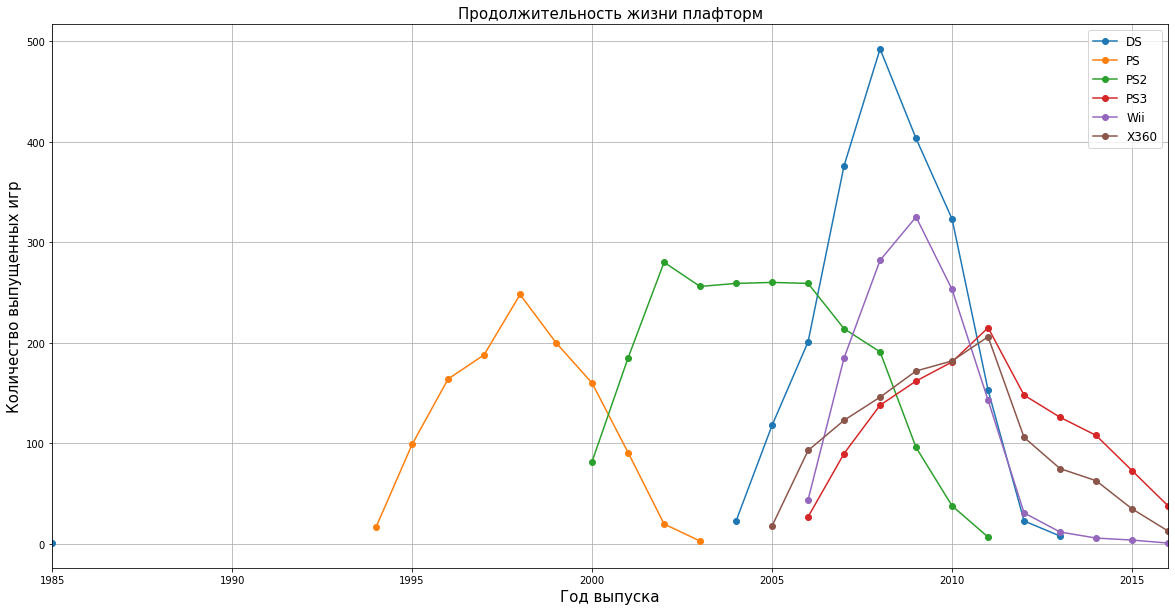

In [42]:
draw_lines(df_top_platform, 'year_of_release')

По графику можем посмотреть, когда появляются и исчезают новые и старые платформы.
* Playstation: платформа появилась в 1994 году и последние игры на нее выходили в 2003 году, консоль просуществовала почти 10 лет;
* Playstation 2: платформа появилась в 2000 году и последние игры на нее выходили в 2011 году, консоль просуществовала почти 11 лет;
* Nintendo DS: видим один выброс 1985 году. Однако отметим, что консоль появилась в 2004 и просущствовала до 2013 года - почти 9 лет;
* Playstation 3: плафторма появилась в 2006 году, но к 2016 году сдает свои позиции
* Nintendo Wii: платформа появилась в 2006 году, а к 2016 году окончательно сдает свои позиции: 10 лет;
* XBOX 360: платформа появилась в 2005 году и аналоггично Playstation 3 сдает свои позиции к 2016 году.

Отсюда делаем предположение, что средняя продолжительность существования плафторма и выпуск для нее игр составляет 10 лет.

Удостоверимся в этом с помощтю расчетов.

In [43]:
def live_platform(df: pd.DataFrame, sort = 'year_of_release', gr = 'platform', title = 'топовых платформ:'):
  first_year = df.sort_values(by = sort).groupby(gr)[sort].first()
  last_year = df.sort_values(by = sort).groupby(gr)[sort].last()
  median_live = (last_year - first_year).median()
  print(f'Среднее время жизни ' + title ,median_live)

In [44]:
live_platform(df_top_platform)

Среднее время жизни топовых платформ: 10.5


Результаты графика подтвердились расчетами. Теперь посмотрим на среднее время жизни всех существовавших или существующих платформ:

In [45]:
live_platform(df, title = 'всех платформ:')

Среднее время жизни всех платформ: 6.0


А вот здесь среднее время жизни плафторм составляет шесть лет. Скорее всего это связано с тем, что есть платформы, которые просуществовали меньше шести лет, а также с научно-технического прогресса современные платформы существуют в среднем 10 лет. Также у нас есть выброс в виде Nintendo DS, первое упоминание которого появляется в 1985 году. Которое, предположительно, могло повлиять на такой показатель.

## Вывод

На основе полученных данных, можно сформулировать следующие выводы:
1. с 1991 года наблюдается постепенный рост выпуска игр, затем наблюдается пик выпущенных игр с 2002 по 2009, далее идет стремительный спад к 2016 году. Это связано с тем, что в период с 2002 по 209 годы, наиболее популярными консолями были: Playstation 2, а к следующему поколени консолей преимущество забрали Playstation 3, XBOX 360, Nintendo DS, чья поддержка к 2016 идут на спад по причине появления современного поколения консолей: Playstation 4 и XBOX one.
2. Среднее время существования платформы составляет 10 лет.

В качестве актуального периода для формирования прогноза на 2017 год возьмем период с 2012 по 2016 год, так как:

1. К 2012 году наблюдается падение продаж игр для платформ старого поколения, если бы мы учли их в дальнейшем исследовании, то мы бы получили некорректные результаты;
2. В этот период появляются новые платформы, для которых, предположительно, будем прогнозировать успешные закономерности;
3. Учитывая среднее время жизни платформы, можно предположить, что исследовать будем платформы нового поколения, которые находятся средней фазе своего существования, в то время как платформы старого поколения будут находиться в конце своей жизни

**Акутальный период**: с 2012 по 2016 год.

In [47]:
df = df.query('year_of_release >= 2012')

## Динамика платформ за акутальный период <a id="3_3"></a>


Построим графики по всем плафтормам за актуальный период

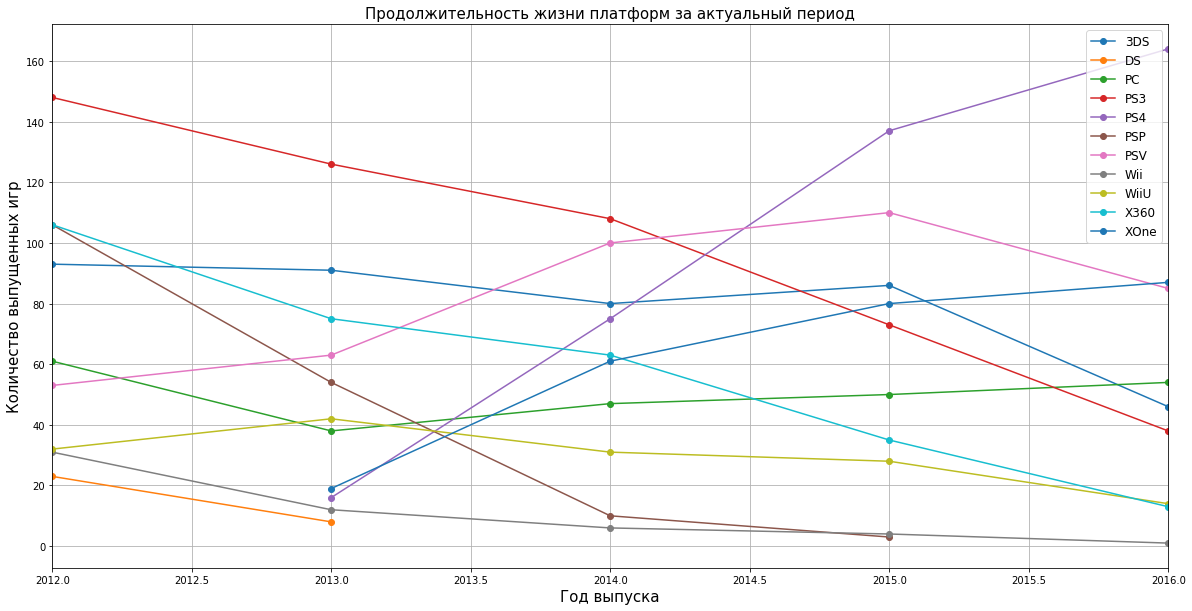

In [48]:
draw_lines(df, 'year_of_release', 'Продолжительность жизни платформ за актуальный период')

## Вывод

По графику видим следующую тендецию: 
* Имеется несколько потенциально прибыльных платформ на 2016 год:
  * Playstation 4;
  * XBOX one;
  * PC
* При этом видим, что у нас наблюдается низкие продажи по всем топ-платформам к 2016 году. Отсюда можно предположить, что рынок игр падает, у людей пропадет интерес к играм, а у разработчиков нет идей для реализации новых игр.
* Видим, что к 2008 году заканчивают свое существование несколько плафторм:
 * GBA;
 * XB;
 * GBC.
* Пик продаж приходится на 2008, 2009 и 2011 годы, при этом с 2011 года наблюдается стабильное снижения спроса по всем живым платформам на рынке видеоигр.

По графику видим следующую тендецию: 
* Имеется несколько потенциально прибыльных платформ на 2016 год:
  * Playstation 4;
  * XBOX one;
  * PC
* Видим, что к 2016 году выпуск игр для старых платформ стремительно падает. Это связано с появлиением консолей нового поколения и увеличение интереса к ним за увеличения производительности и перехода разработчиков игр к выпуск своих продуктов для приставок нового поколения.

## Анализ глобальных продаж <a id="3_4"></a>


Построим диграммы размаха глобальных продаж. Построим следующие диаграммы размаха:
* Диаграмма размаха глобальных продаж по всем платформам за актуальный период;
* Диаграмма размаха глобальных продаж в разбивке по популярным платформам за актуальный период.

Насчет диаграммы размаха в разбивке по популярным платформам за актуальный период: решили использовать потенциальные топ-платформы и платформы по топ-продажам, чтобы сравнить, как у нас распределены продажи по платформам и посмотреть динамику платформ прошлого поколения с динамикой нового поколения.

In [49]:
def boxplot(df: pd.DataFrame, title = 'Глобальные продажи игр по всем платформам за актуальный период', query = None, ylim = None):
  if query == None:
    ax = df.boxplot(column='total_sales', 
                    figsize = (20,10),
                    boxprops=dict(linestyle='-', linewidth=3),
                    medianprops=dict(linestyle='-', linewidth=3, color = 'blue'),
                    whiskerprops=dict(linestyle='-', linewidth=3),
                    capprops=dict(linestyle='-', linewidth=3),
                    fontsize=15
                    )
    if ylim != None:
        ax.set_ylim(ylim)
    plt.suptitle(title, fontsize=15)
    return df.total_sales.describe()
  else:
    df = df.query(query)
    groupby_elem = query.split()[0]
    ax = df.boxplot(column='total_sales', 
                    figsize = (20,10),
                    by = groupby_elem,
                    boxprops=dict(linestyle='-', linewidth=3),
                    medianprops=dict(linestyle='-', linewidth=3, color = 'navy'),
                    whiskerprops=dict(linestyle='-', linewidth=3),
                    capprops=dict(linestyle='-', linewidth=3),
                    fontsize=15
                    )
    if ylim != None:
        ax.set_ylim(ylim)
    plt.suptitle(title, fontsize=15)
    return df.groupby(groupby_elem)['total_sales'].describe()

count    2886.000000
mean        0.501223
std         1.249157
min         0.010000
25%         0.040000
50%         0.120000
75%         0.430000
max        21.050000
Name: total_sales, dtype: float64

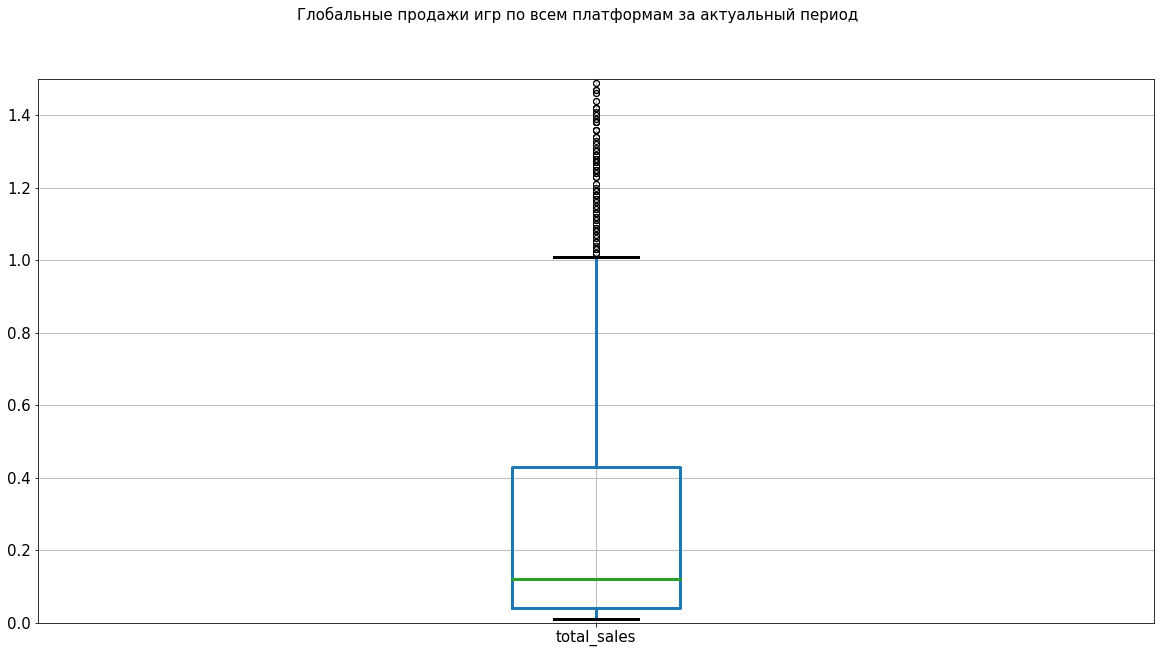

In [50]:
boxplot(df, ylim = [0,1.5])

Видим, что по всем платформам в период с 2012 по 2016 год в среднем продается 500 тысяч копий игр. Медианное значение составляет 120 тысяч проданных копий. Причина в таком разбросе значений в том, что здесь учитыватся платформы, цикл жизни которых подошел к концу. Более того, в списке игр могли пристутствовать малопопулярные проекты, чьи продажи могли достигать 10 тысяч проданных копий. При этом у нас есть проекты, глобальные продажи которых достигли больше 10 млн. проданных копий.

Теперь рассмотрим диаграммы размаха в разбивке по платформам за акутальный период.

In [51]:
top_platform = ['DS', 'PS2', 'PS3', 'PS4', 'Wii', 'X360', 'XOne', 'PC', '3DS']

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,396.0,0.491439,1.387161,0.01,0.0400,0.11,0.3125,14.60
DS,31.0,0.404839,1.439245,0.01,0.0200,0.05,0.1850,8.06
PC,250.0,0.250600,0.494640,0.01,0.0300,0.08,0.2400,5.14
PS3,493.0,0.585781,1.462855,0.01,0.0500,0.20,0.6100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.20,0.7300,14.63
Wii,54.0,0.655000,1.165447,0.01,0.0625,0.18,0.6875,6.76
X360,292.0,0.810068,1.712069,0.01,0.1000,0.31,0.8700,16.27
XOne,247.0,0.645020,1.036139,0.01,0.0600,0.22,0.6850,7.39


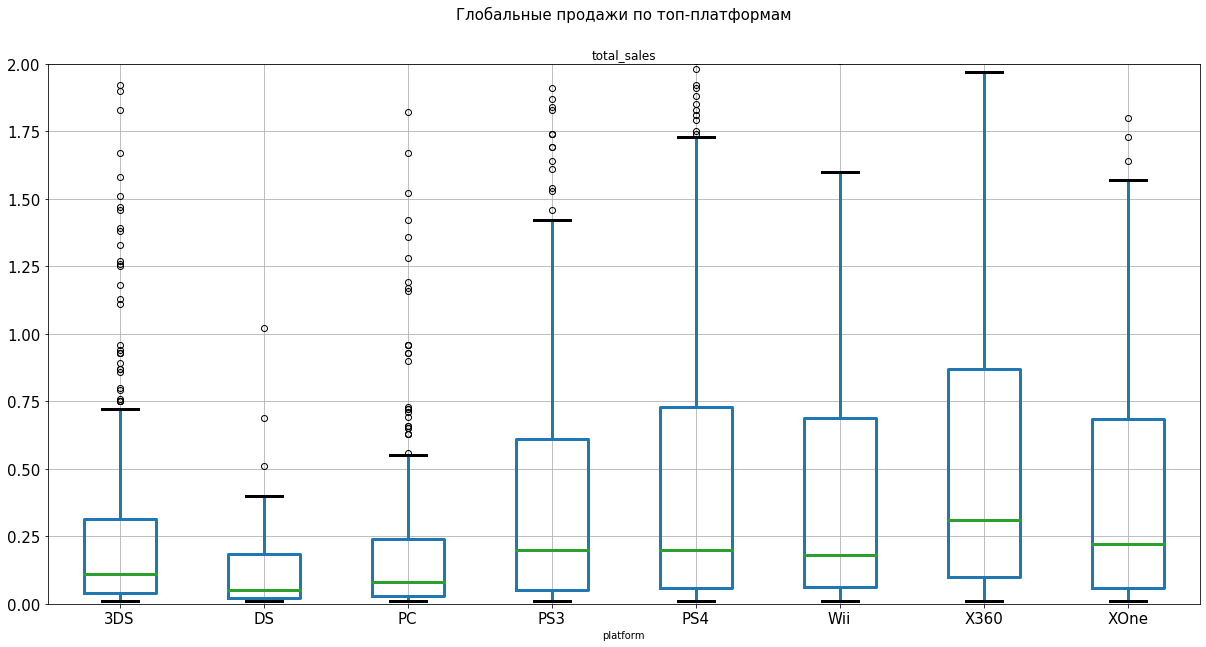

In [52]:
boxplot(df, query = 'platform in @top_platform', ylim = [0,2], title = 'Глобальные продажи по топ-платформам')

## Вывод

Здесь мы видим следующее:
* по потенциальный платформам:
  * медианное количество проданных копий в пределах от 50 до 200 тысяч проданных копий
  * аутсайдер - PC, с медианным показателем в 50 тысяч проданных копий, это связано с тем, что на момент 2016 года, большиство пользователей, которые играли на PC использовали пиратский контент, отсюда и низкий показатель продаж данной платформы
  * Лидером по продаж игр среди потенциальных платформ - playstation 4. Верхняя граница по продаже игр составляет 1.7 миллиона проданных копий и в среднем продается 800 тысяч копий.
* по топ-платформам:
 * медиана по топовым платформам варьируется от 50 до 280 тысяч проданных копий
 * верхняя граница у двух платформ: Playstation 3 и XBOX 360 на уровне 1.7 млн. проданных копий, остальные платформы в пределах 1 млн. проданных копий.
 * аутсайдером среди топ-платформ является Nintendo DS со средней продажей в 370 тысяч копий игры. Это может связано с тем, что к 2016 году данная плафторма находится в конце жизни своего существования. Однако такая плафторма может быть популярна в Японии и среди детей благодаря своей портативности.

 По общим наблюдениям видим:
 * меньше всего копий игры продаются на платформе PC. При этом не ясно, как проводится подсчет проданных копий на физическом или электронном носителе. Более того учитываем тот факт, что спиратить игру на PC проще, чем на всех остальных платформах.
 * Видим потенциал у двух консолей: PS4 и XOne. К 2016 году наблюдается спад продаж игр для платформ предыдущего поколения, в то время как для нового поколения это только средняя фаза жизни платформ. Видим, что по врехней границе проданных копий находится PS4, которая выше, чем у PS3 и XBOX 360.
 * Людей, которые играют на игровых приставках больше, чем людей, которые играют на PC

In [53]:
top_platform = [ 'PS3', 'PS4', 'XOne', 'PC', '3DS']

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,396.0,0.491439,1.387161,0.01,0.04,0.11,0.3125,14.60
PC,250.0,0.250600,0.494640,0.01,0.03,0.08,0.2400,5.14
PS3,493.0,0.585781,1.462855,0.01,0.05,0.20,0.6100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.06,0.20,0.7300,14.63
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.6850,7.39


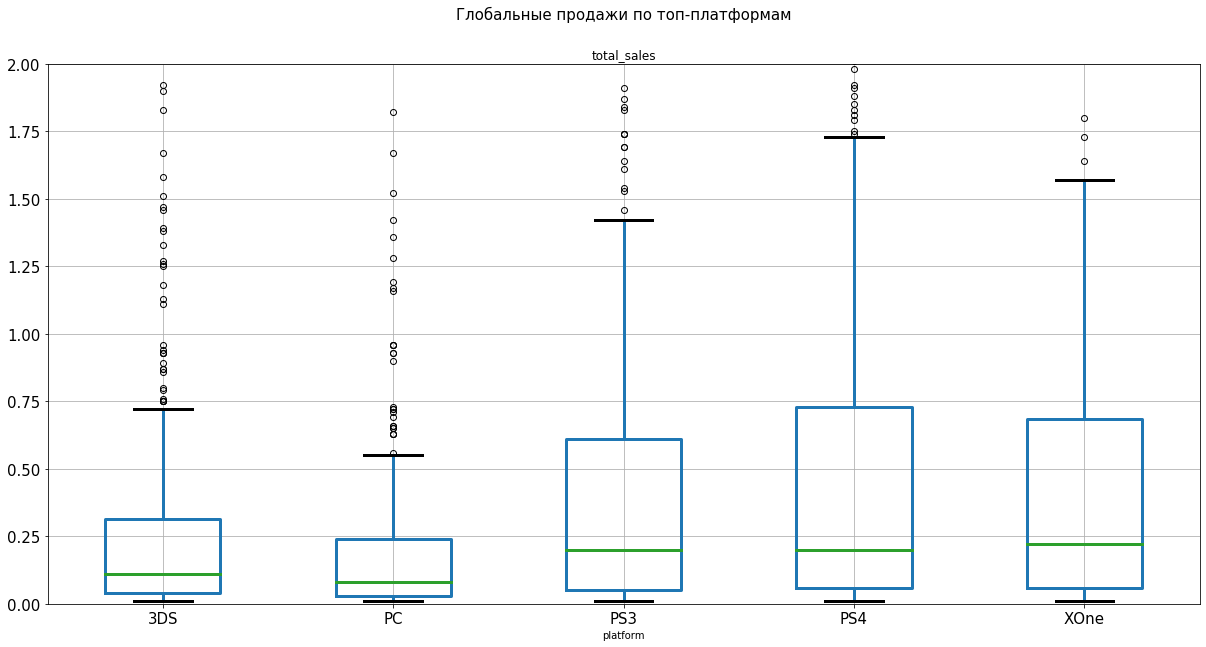

In [54]:
boxplot(df, query = 'platform in @top_platform', ylim = [0,2], title = 'Глобальные продажи по топ-платформам')

Здесь мы видим следующее:
* по потенциальный платформам:
  * медианное количество проданных копий в пределах от 50 до 200 тысяч проданных копий
  * аутсайдер - PC, с медианным показателем в 50 тысяч проданных копий, это связано с тем, что на момент 2016 года, большиство пользователей, которые играли на PC использовали пиратский контент, отсюда и низкий показатель продаж данной платформы
  * Лидером по продаж игр среди потенциальных платформ - playstation 4. Верхняя граница по продаже игр составляет 1.7 миллиона проданных копий и в среднем продается 800 тысяч копий.
  
 По общим наблюдениям видим:
 * меньше всего копий игры продаются на платформе PC. При этом не ясно, как проводится подсчет проданных копий на физическом или электронном носителе. Более того учитываем тот факт, что спиратить игру на PC проще, чем на всех остальных платформах.
 * Видим потенциал у двух консолей: PS4 и XOne. К 2016 году наблюдается спад продаж игр для платформ предыдущего поколения, в то время как для нового поколения это только средняя фаза жизни платформ. Видим, что по врехней границе проданных копий находится PS4, которая выше, чем у PS3 и XBOX 360.
 * Людей, которые играют на игровых приставках больше, чем людей, которые играют на PC

## Исследование влияния оценок критиков и игроков на продажи одной популярной платформы. <a id="3_5"></a>


В качестве популярной платформы можем выбрать следующие категории плафтормы:
1. Популярная платформа предыдущего поколения: здесь мы можем увидеть полный цикл существования платформы и отследить продажи игры в зависимости от оценки игроков и критиков;
2. Популярная потенциальная платформа нового поколения. Так как она, предоположительно имеет схожий потенциал с платформами старого поколения.

Однако мы делаем прогноз на 2017 год, результаты которого повлияют на потенциальный продукт.

Поэтому в качестве популярной платформы выберем Playstation 4.

In [55]:
df_ps4 = df[df.platform == 'PS4']

In [56]:
def draw_corr(df : pd.DataFrame, column: str, label = 'Оценка критиков'):
  df.plot(kind = 'scatter', x = column, y = 'total_sales', figsize = (20,10))
  plt.ylabel('Глобальные продажи')
  plt.xlabel(label)   

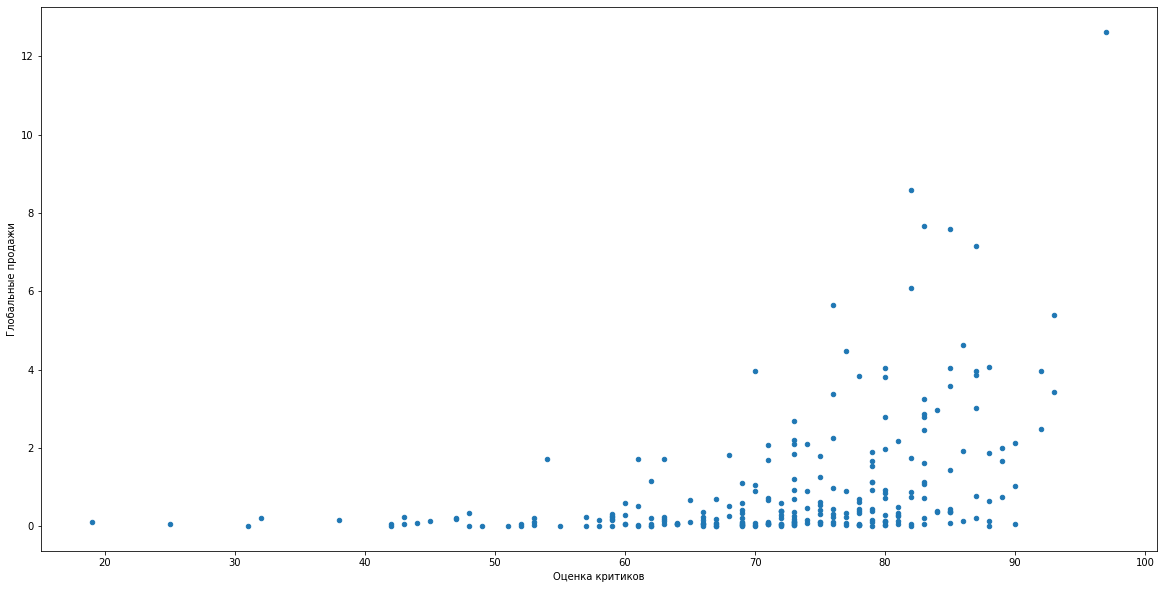

In [57]:
draw_corr(df_ps4, 'critic_score')

## Вывод

На основе графика видим следующее: чем выше средняя оценка критиков, тем больше игр продается. Неудивительно, так как люди, которые увлекаются играми, зачастую ориентируются на мнение критиков, журналистов, которые имеют большой опыт в игровой индустрии и способны объективно оценивать игры.

Рассмотрим как влияет оценка пользователей на количество проданных копий:

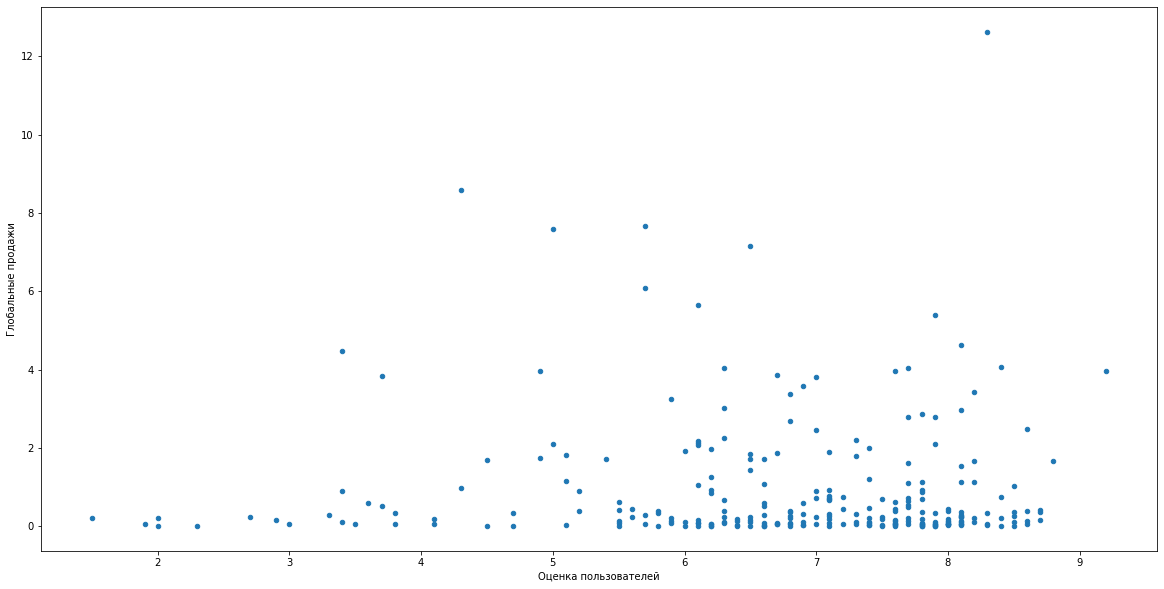

In [58]:
draw_corr(df_ps4, 'user_score', 'Оценка пользователей')

Здесь мы видим примерно аналогичную картину: чем выше пользовательская оценка, тем больше игру покупают. Однако видим, что выбросов с большим количеством проданных игр и плохой оценкой игр больше по сравнению с оценкой критиков, а также такая тенденция не так ярко выражена по сравнению с оценкой критиков.

Это связано с тем, что некоторые игроки более критичны и субъективно настроены к оценке игр. При этом возможен случай, когда у определенной игры есть большой ажиотаж, а затем продукт не превзошел ожиданий, поэтому пользователи стремятся ставить низкие оценки.

Построим матрицу корреляции и определим, как численно зависит количество проданных копий от оценок пользователей и критиков.

In [59]:
df_ps4 = df_ps4[['critic_score', 'user_score', 'total_sales']]

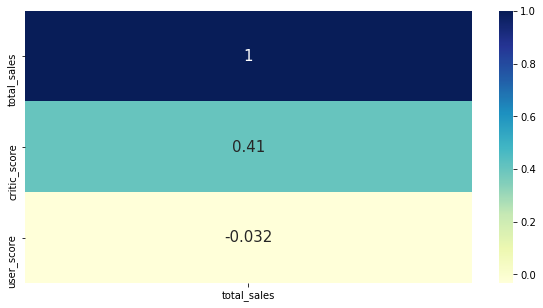

In [60]:
plt.figure(figsize = (10,5))
sns.heatmap(df_ps4.corr()[['total_sales']].sort_values(by = 'total_sales', ascending = False), annot = True, annot_kws = {'size' : 15}, cmap="YlGnBu")

## Вывод

Видим, что у нас оценка критиков влияет больше на число проданных копий, чем оценка пользователей, которая практически не влияет на продажу игр. Причина таких показателей может быть связана с тем, что люди прислушиваются к мнению критиков больше, чем к мнению пользователей. Так как игровые журналисты и критики стремятся объективнго оценивать продукт, который в дальнейшем будет иметь спрос у окончательного потребителя.

Теперь посмотрим на остальные платформы, как на них влияют оценки пользователей и критиков.

In [61]:
top_platform = ['PS3', 'PS4', 'X360', 'PC', 'XOne', '3DS']

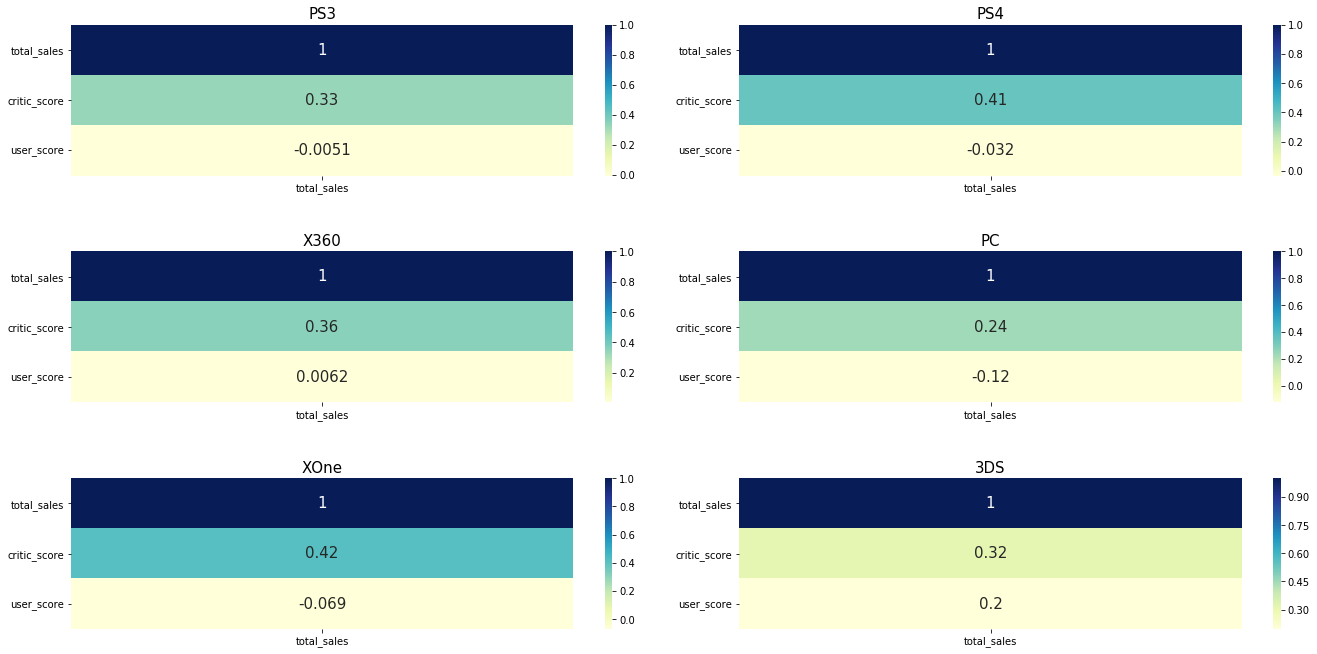

In [62]:
rows = (len(top_platform) // 2)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize = (20, 10))
count = 0
for row in range(rows):
  for col in range(cols):
    platform = top_platform[count]
    df_platform = df[df.platform == platform][['critic_score', 'user_score', 'total_sales']]
    ax = sns.heatmap(df_platform.corr()[['total_sales']].sort_values(by = 'total_sales', ascending = False), 
                     annot = True, 
                     annot_kws = {'size' : 15}, 
                     cmap="YlGnBu",
                     ax = axes[row, col])
    ax.set_title(platform, fontsize = 15)
    plt.tight_layout(pad=4)
    count+=1

## Вывод

Итак, по остальным платформам мы видим идентичную картину по сравненнию с выбранной популярной платформой: оценка критиков влияет на пролдажи игр больше, по сравнению с оценкой пользователей.

Однако видим, что у нас меньше всего оценки критиков и пользователей влияют на продажи игр на плафторме Wii. Скорее всего, это связано с тем, что данная платформа ориентировалась на азиатский рынок, который имеет, предположительно, свои пожанровые предпочтения по сравнению с другими регионами.

Большой показатель влияния оценки критиков на продаж связано с тем, что игроки зачастую перед покупкой игры смотрят на отзывы, обзоры компетентных в игровой сфере людей, т.е. критиков, способные объективно оценить и порекомендовать продукт.

Низкий показатель пользовательской оценки связано с тем, что люди склонны больше доверять критику или эксперту в игровой индустрии в плане игр вместо других игроков. Более того, в игровой индустрии на практике обзор на игру от критиков выходит за день до релиза игры, что может повлиять на решение о покупке игры пользователем.

Теперь посмотрим на количество продаж и количество игр выпущенных за актуальнй период пожанрово.

## Распределение игр по жанрам <a id="3_6"></a>


Построим столбчатые диаграммы по количеству и общей сумме продаж игр пожанрово.

In [63]:
df_genre = df.groupby('genre').agg({'name' : 'count', 'total_sales' : 'sum'}).sort_values(by  = 'name', ascending = False)

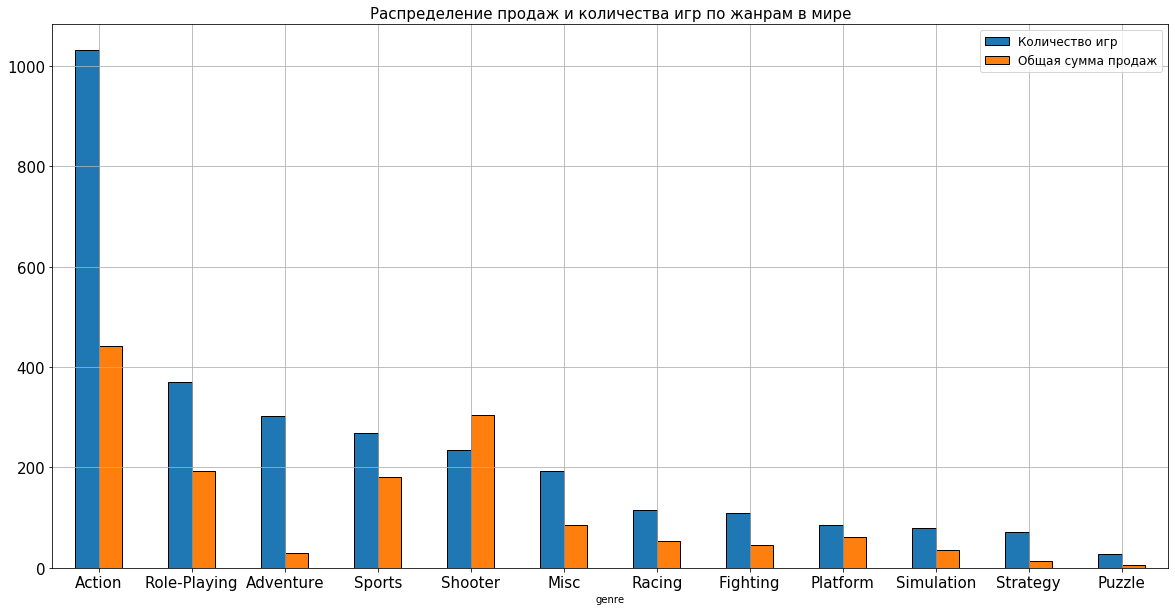

In [64]:
ax = df_genre.plot(kind = 'bar',
                  ec = 'black', 
                  grid = True,
                  figsize = (20,10),
                  title = 'Распределение продаж и количества игр по жанрам в мире',
                   rot = 0)
ax.legend(['Количество игр', 'Общая сумма продаж'], prop={'size': 12})
ax.title.set_fontsize(20)
for item in ([ax.title] +ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

## Вывод

с 2005 по 2016 год вышло больше всего игр жанра **Action**, **Sports**, **Misc** (игры смешанного жанра). При этом обратим внимание, что хоть и игры жанра **Action** значительно больше всех остальных игр, но по общей сумме продаже практически равна играм жанра **Sport**. Это неудивительно, так как если посмотреть на топ-продаж (в том числе британский [чарт](https://dtf.ru/gamedev/3468-dohody-igrovogo-rynka-velikobritanii-upali-pochti-na-16-za-2016-god) топ-продаж), то можно заметить, что в топе находится симулятор футбола FIFA, то есть, игроки предпочитают играть в спортивные симуляторы. Однако за счет объема игр жанра **Action** общая сумма продаж игр этого жанра превышает спортивные симуляторы.

Видим, что за актуальный период меньше всего вышло игр жанра **fighting**, **platform**, **strategy**, **Puzzle**. Это говорит нам о том, что эти жанры малопопулярны и имеют узкую аудиторию игроков.

Самый неудачный жанр - это **adventure**. Видим, что выпущено игр много, а количество продаж на уровне **Puzzle**. Это говорит нам о том, что игровые студии имеют большое количество идей и реализовывают их в свой продукт, однако малопопулярно среди игроков.

**Топ по количеству выпущенных игр**:
1. Action;
2. Sports;
3. Misc.

**Топ по количеству проданных копий**:
1. Action;
2. Sports;
3. Shooter.

Теперь рассмотрим разные регионы продаж.

In [65]:
df_genre = df_genre.reset_index()
df_genre.columns = ['genre', 'name', 'total_sales']

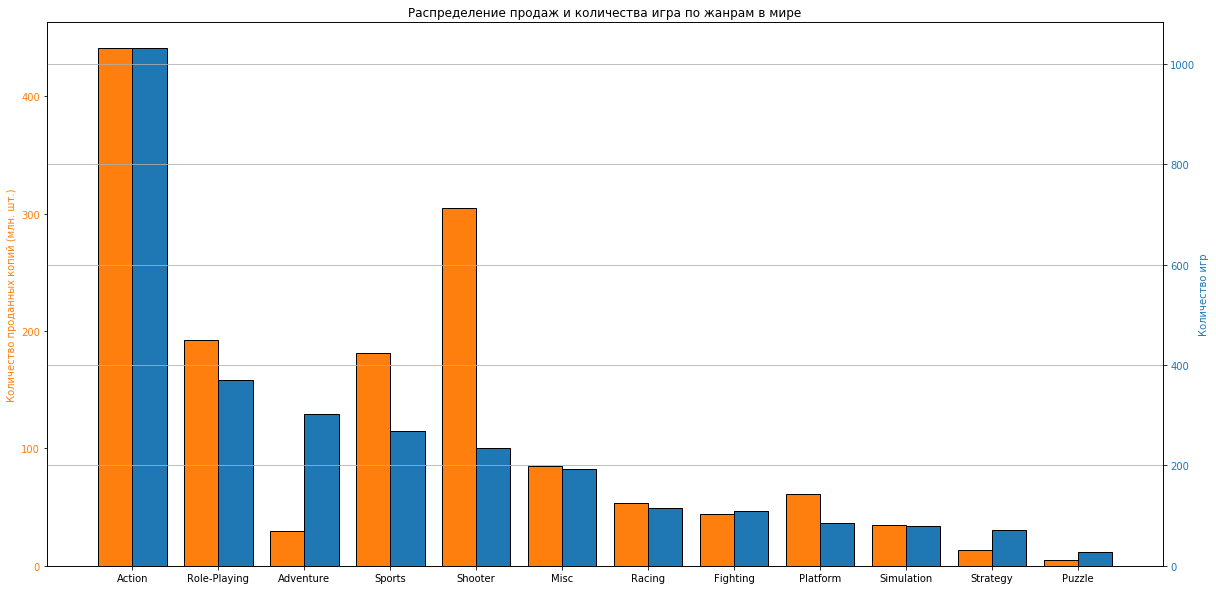

In [66]:
fig, ax1 = plt.subplots(figsize = (20,10))
width = 0.4
x = np.arange(len(df_genre))
color = 'tab:orange'
ax1.set_ylabel('Количество проданных копий (млн. шт.)', color=color)
ax1.bar(x - 0.2, df_genre['total_sales'], color=color, width = width, ec = 'black', label = 'Количество проданных копий (млн. шт.)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Количество игр', color=color)
ax2.bar(x + 0.2, df_genre['name'], color=color, width = width, ec = 'black', label = 'Количество игр')
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(df_genre.index, df_genre.genre)
plt.grid(True)
plt.xlabel('Наименование жанра')
plt.title('Распределение продаж и количества игра по жанрам в мире')
plt.show()
plt.rcParams['font.size'] = '14'

В период с 2012 по 2016 год вышло больше всего игр жанра **Action**, **Role-Playing** и **Adventure** при этом видим, что по количеству проданных копий лидируют следующие жанры: **Action**, **Shooter**, **Role-Playing** и **Sports**. Людям больше интересны игры с экшн-сценами и стрельбой (учитвая соотношение количества продаж и выпущенных игр)

Видим, что малопопулярные жанры, для которых меньше всего выходит игр представлены в виде жанров **Puzzle**, **Strategy**. Такие жанры имеют очень узкую аудиторию и имеют, соответственно, низкий спрос.

Самый неудачный жанр - это **adventure**. Видим, что выпущено игр много, а количество продаж на уровне **Puzzle**. Это говорит нам о том, что игровые студии имеют большое количество идей и реализовывают их в свой продукт, однако малопопулярно среди игроков.


**Топ по количеству выпущенных игр**:
1. Action;
2. Role-Playing;
3. Adventure.

**Топ по количеству проданных копий**:
1. Action;
2. Role-Playing;
3. Shooter.

Теперь рассмотрим разные регионы продаж.

## Портрет пользователя каждого региона <a id="4"></a>

---

## Самые популярные платформы <a id="4_1"></a>

Рассмотрим какие платформы были популярны в разных регионах в период с 2012 по 2016 год.

In [67]:
def plot(df: pd.DataFrame, 
         groupby_col: str, 
         type : str, 
         ylim = None):
  col = 3
  row = 1
  fig, axes = plt.subplots(row, col, figsize = (20,10))
  axes[0].set_ylabel('Количество проданных копий игр (млн. шт)', fontsize = 15)
  list_sales = ['na_sales', 
                'eu_sales', 
                'jp_sales']
  list_sales_names = ['Продажи в Северной Америке', 
                      'Продажи в Европе', 
                      'Продажи в Японии']
  if groupby_col == 'platform':
    title = 'по платформам'
  elif groupby_col == 'genre':
    title  = 'по жанрам'
  elif groupby_col == 'rating':
    title = 'по рейтингу ESRB'
  else:
    title = groupby_col
  plt.suptitle('Количество проданных копий игр ' + title) 
  if type == 'plot':
    color = ['red', 
           'orange', 
           'navy']      
    for i in range(col):
      df_sales =(
        df.groupby(groupby_col)[list_sales[i]].sum().sort_values(ascending = False)[:5]  
      ) 
      df_sales.plot(kind = 'bar', 
                  ax = axes[i], 
                  rot = 0, 
                  title = list_sales_names[i],
                  legend = True, 
                  color = color[i],
                  grid = True,
                  ec = 'black',
                  ylim = ylim)
  elif type == 'pie':
    for i in range(col):
      df_sales = (
         df.groupby(groupby_col)[list_sales[i]].sum().sort_values(ascending = False)[:5] 
      )
      df_sales.plot(kind = 'pie', 
                  ax = axes[i], 
                  rot = 15, 
                  title = list_sales_names[i],
                  autopct = "%0.2f%%",
                  startangle = 60)

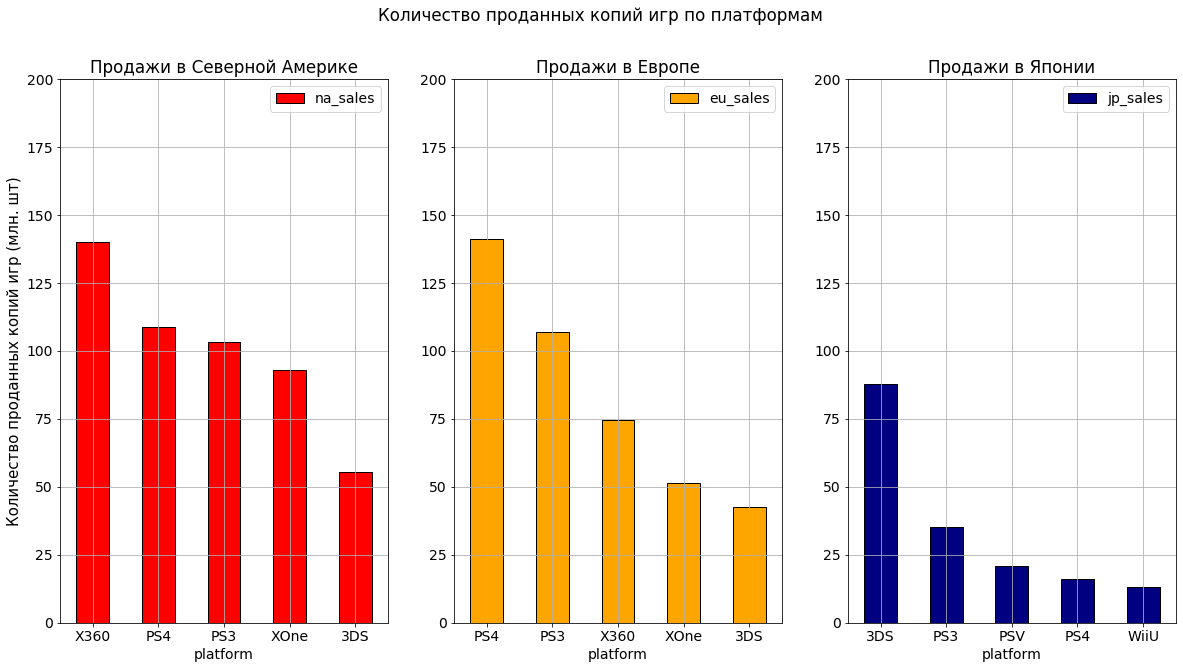

In [68]:
plot(df, 'platform', 'plot', (0,200))

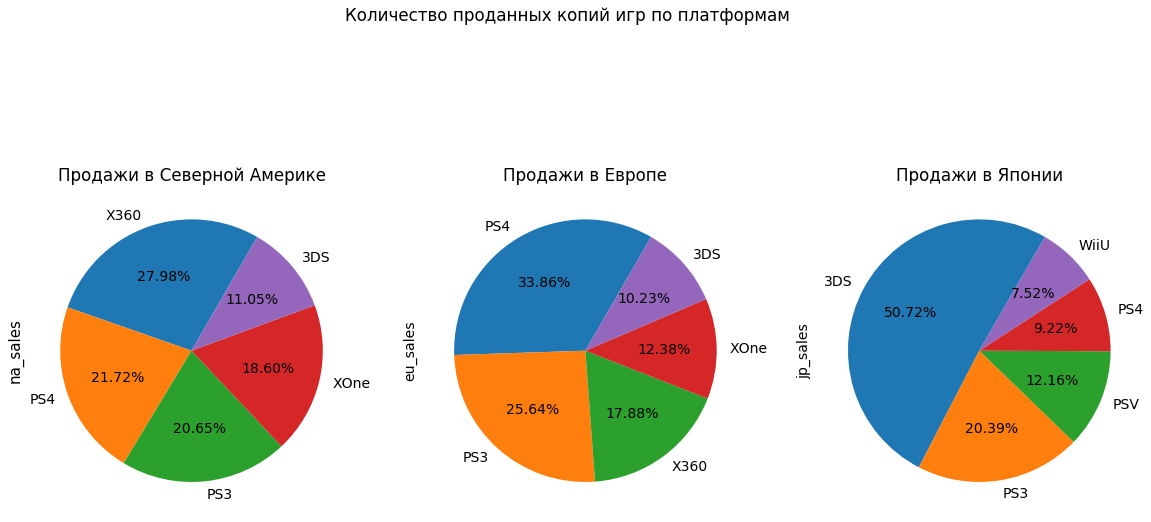

In [69]:
plot(df, 'platform', 'pie')

## Вывод

На основе полученных данных за период 2012 по 2016 годы можем заметить следующее:
* В Северной Америке самыми популярными платформами представлены следующие консоли:
    * XBOX 360
    * Playstation 4 
    * Playstation 3
    
Это связано с тем, что XBOX 360 выходил в разынх версиях, с разной стоимостью, при этом для пиратов был более доступной приставкой, которую можно было легко взломать и играть в игры бесплатно. Более того XBOX 360 - приставка, разработчики которой прежде всего ориентировались на внутренний рынок. Видим, что среди нового поколения Playstation 4 популярнее своего конкурента: XBOX ONE. Это связано с неудачной политикой Microsoft в реализации своей приставки нового поколения (акцент на соц.сервисы, меньше игр, ради которой стоило покупать приставку, выше цена, так как XBOX ONE выпускался сразу с Kinect, что делала приставку дороже, чем ее конкурент).

* В Европе самые популярные платформы представлены в таком порядке:
    * Playstation 4
    * Playstation 3

Это связано с тем, что XBOX 360 стремился покорить собственный регион, а также к 2016 году Sony выпустила несколько версий своей игровой приставки, которые по цене были предпочтительны, по сравнению с XBOX 360. Более того, предполагаем, что мало к Европе знал о существовании XBOX, в том время как бренд Playstation был у многих на слуху благодаря успеху Playstation 2. Добавим, что в топ ворвалась Playstation 4, которая на состояние 2016 года находилась в середине своего существования, но из-за плачевого состояния рынка игр к 2016, данная платформа не получила той популярности, которые достигли предыдущие поколения.

* На японском рынке весь топ представляет из себя исключительно продукты японских компаний, которые зарекомедовали себя благодаря приставкам предыдущих поколений: Nintendo и Sony. Однако в Японии наиболее популярен мобильный гейминг, что мы и видим по графику - на первом месте **Nintendo 3DS**, а за ним следует **Playstation 3**

Теперь посмотрим, какие жанры были популярны в разных регионах.

## Какие жанры популярны <a id="4_2"></a>


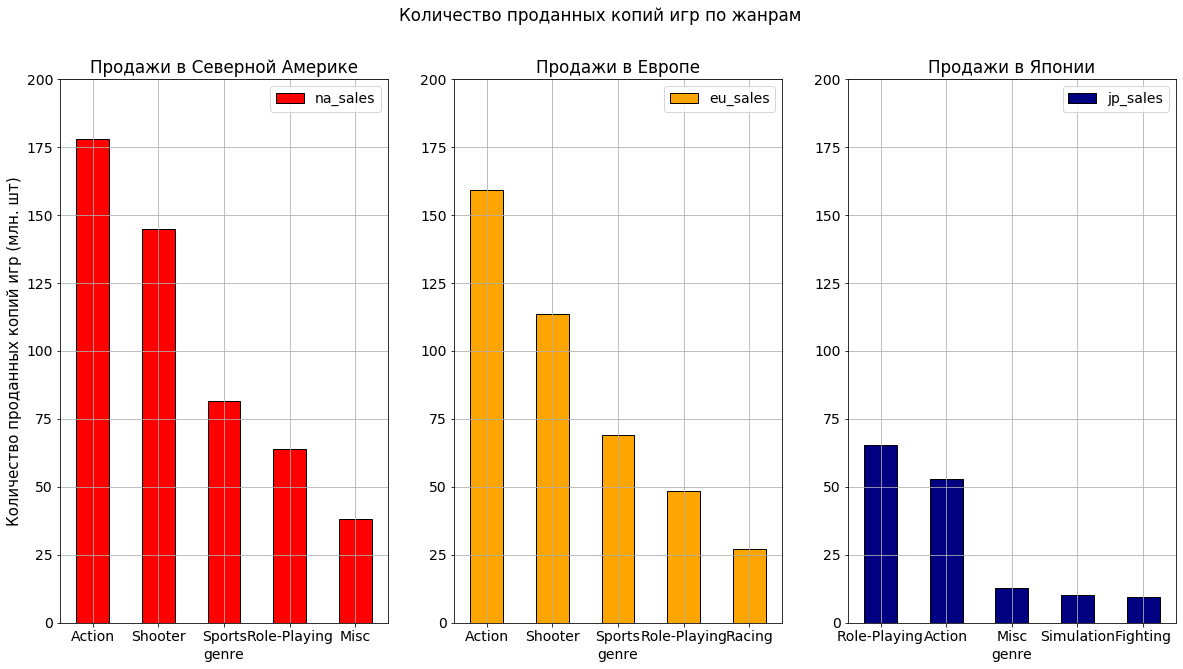

In [70]:
plot(df, 'genre', 'plot', (0,200))

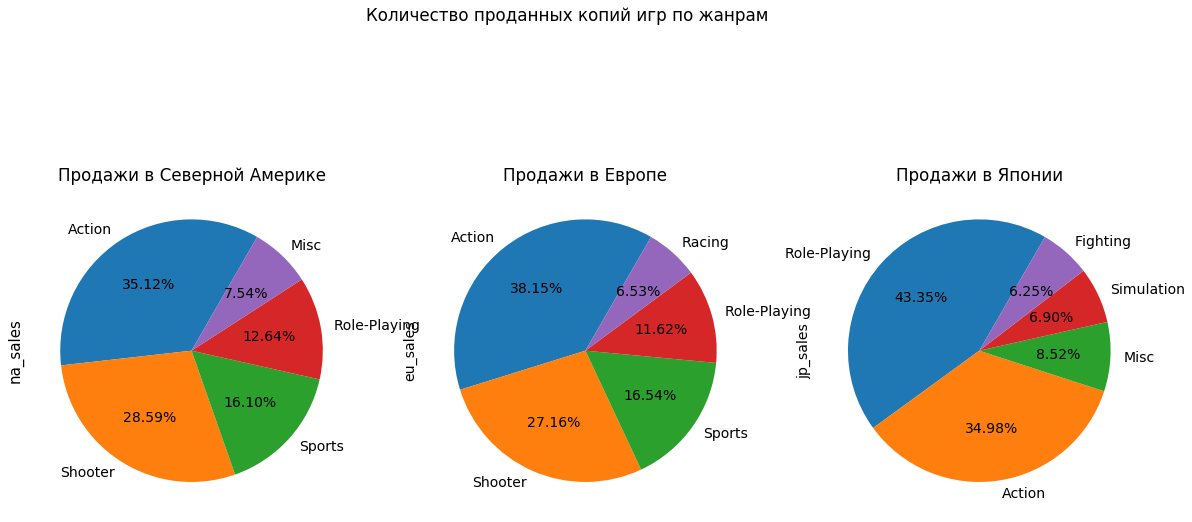

In [71]:
plot(df, 'genre', 'pie')

## Вывод

Здесь мы видим следующую картину:
* В Европе и Северной Америке популярные жанры сходятся: 
  * **Action**
  * **Sports**
  * **Shooter**
  
Однако в Европе предпочитают больше играть в гонки, а в Северной Америке - игры смешанного жанра. Предположительно, основные студии, которые разрабатывают игры подобных форматов расположены в данных регионах. Разработчики игр знают свою ЦА и их предпочтения, поэтому подобные жанры популярны в Европе и Северной Америке.

А вот с Японией картина отличается от остальных в сравнении регионов. Японцы предпочитают играть в **ролевые игры**. Видимо, эта привычка появилась еще в эпоху первых платформ, когда японские разработчики выпускали платформеры и ролевые игры. И скорее всего, японцы любят погружаться во вселенную игры и ощущать себя главным героем ролевой игры.

Чтобы представить портрет среднего пользователя каждого регина определим, как рейтинг влияет на продажи игры.

## Как рейтинг ESRB влияет на продажи игр в каждом регионе? <a id="4_3"></a>

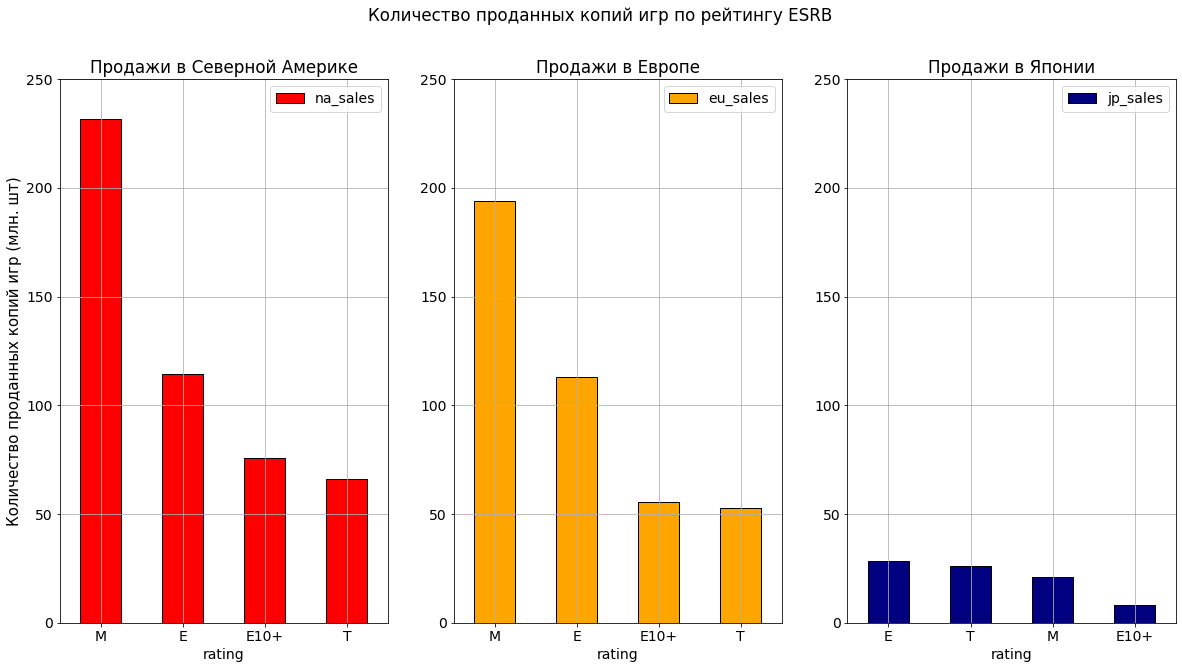

In [72]:
plot(df, 'rating', 'plot', (0,250))

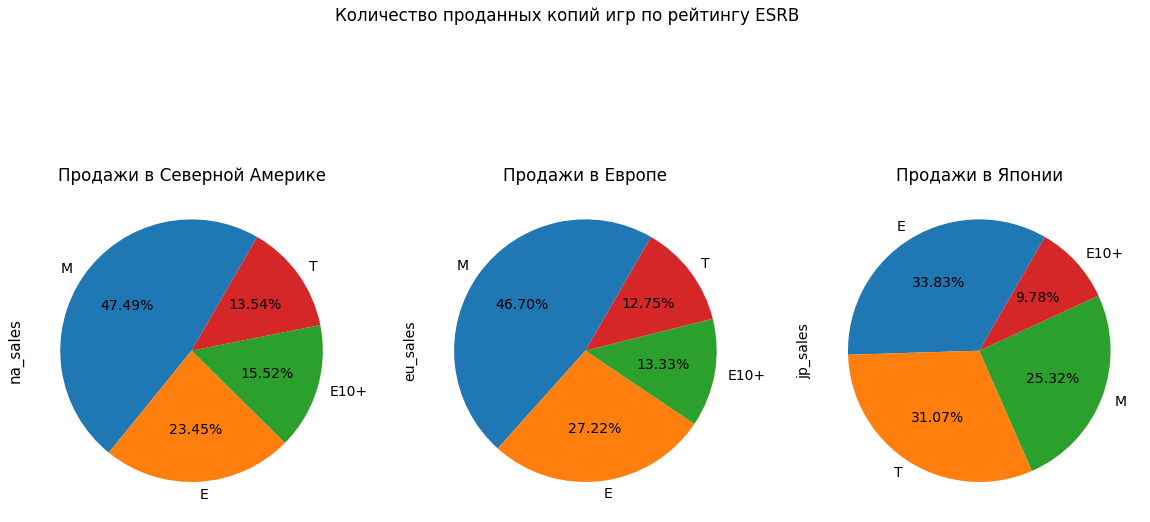

In [73]:
plot(df, 'rating', 'pie')

## Вывод

Вспомним классификации возрастного рейтинга ESRB:
> * **«EC» («Early childhood»)** — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры. Некоторые усложнённые развивающие игры могут иметь рейтинг «Everyone».
* **«E» («Everyone»)** — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера
* **«E10+» («Everyone 10 and older»)** — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. 
* **«T» («Teen»)** — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.
* **«M» («Mature»)** — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.
* **«AO» («Adults Only 18+»)** — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением.

На основе полученных данных можем заметить следующее:
* Возрастные рейтинги для Северной Америки и Европы совпадают. Во всех регионах больше всего игр покупают с возраcтным рейтингом **M** - для взрослых. Что, на самом деле, неудивительно. Так как если посмотреть на самые популярные жанры в этих регионах, то это: Шутеры, Экшены, которые наполнены жестокими сценами насилия и большим количеством реалистичных сцен перестрелки.
* После рейтинга **для взрослых** в Европе и Америке следует рейтинг **Е** - для всей семьи. Так как основная ЦА компаний-разработчиков игр - это семья (дети, родители, старшее поколение). Родители покупают игры своим детям исходя из возрастного рейтинга. При этом за игрой родители вместе с детьми могут чаще проводить время, общаясь друг с другом, а старшее поколение может играть в такие игры благодаря простом управлению и отсутствием жестоких сцен.
* Япония по сравнению с остальными регионами ведут себя сдержано и предпочитают играть в игры, которые содержат миниум насилия - для всей семьи и подростков. Это может быть связано с культурными особенностями Японии и жесткой цензурной политикой в этой стране.

## Вывод 

На основе полученных результатов для каждого региона получили следующие предпочтения и популярные платформы на 2016 год:

|**Регион**|**Популярная платформа**|**Популярный жанр**|**Возрастной рейтинг**|
|:--------:|:----------------------:|:-----------------:|:--------------------:|
|**Северная Америка**|**XBOX 360**, **Playstation 4**|**Action**, **Sports**, **Shooter**|**E**, **M**|
|**Европа**|**Playstation 4**|**Action**, **Sports**, **Shooter**|**E**, **M**|
|**Япония**|**Nintendo 3DS**|**Role-Playing**, **Action**|**E**, **T**|

После того, как посмотрели на региональные предпочтения игроков, перейдем к формулированию гипотез.

## Проверка гипотез <a id="5"></a>

---

В рамках исследования необходимо проверить следующие гипотезы:

1. Средние пользовательские рейтинги платформ Xbox one и PC **одинаковые**;
2. Средние пользовательские рейтинги жанров **action** и **sports** различаются.

Выборки, средние которых мы будем сравнивать, независимы друг от друга, поэтому для сравнения выборок будем использовать t-критерий Стьюдента. Прежде чем начнем сравнивать выборки для каждой гипотезы, сделаем необходимые выборки и сравним для каждой группы дисперсии.

Рассмотрим гипотезу: средние пользовательские рейтинги платформ Xbox one и PC **одинаковые**;

In [74]:
df_xone_users_score = df[(df.platform == 'XOne') & (df.user_score.isna() == False)][['user_score']]
df_pc_users_score = df[(df.platform == 'PC') & (df.user_score.isna() == False)][['user_score']]
# ddof = 1 используется для того, чтобы получить дисперисю для выборки
print('Дисперсия выборки пользовательские оценки игр на xbox one:', np.var(df_xone_users_score, ddof = 1))
print('Дисперсия выборки пользовательские оценки игр на PC:' , np.var(df_pc_users_score, ddof = 1))

Дисперсия выборки пользовательские оценки игр на xbox one: user_score    1.906997
dtype: float64
Дисперсия выборки пользовательские оценки игр на PC: user_score    2.770444
dtype: float64


Видим, что дисперсии этих выборок отличаются. Поэтому при сравнении выборок используем параметр `equal_var = False`

Теперь сформируем следующие гипотезы:
* **Нулевая гипотеза**: средние пользовательские рейтинги платформ Xbox one и PC **одинаковые**;
* **Альтернативная гипотеза**: средние пользовательские рейтинги платформ Xbox one и PC **различаются**;

In [75]:
def hypotesis(s1: pd.Series, s2: pd.Series):
  alpha = .05
  results = st.ttest_ind(s1, s2, equal_var = False)
  print('p-значeние:', results.pvalue)
  if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
  else:
    print('Не удалось отвергнуть нулевую гипотезу')

In [76]:
hypotesis(df_xone_users_score, df_pc_users_score)

p-значeние: [0.5489538]
Не удалось отвергнуть нулевую гипотезу


Разница между выборками случайна и статистически незначима. Таким образом, можем сказать, что средние пользовательские рейтинги **одинаковы**

Теперь рассмотрим следующую гипотезу:

Средние пользовательские рейтинги жанров **action** и **sports** различаются.

Для сформируем выборки и посчитаем дисперисии, затем определим нулевую и альтернативную гипотезы

In [77]:
df_action_users_score = df[(df.genre == 'Action') & (df.user_score.isna() == False)][['user_score']]
df_sports_users_score = df[(df.genre == 'Sports') & (df.user_score.isna() == False)][['user_score']]
# ddof = 1 используется для того, чтобы получить дисперисю для выборки
print('Дисперсия выборки пользовательские оценки игр жанра Action:', np.var(df_action_users_score, ddof = 1))
print('Дисперсия выборки пользовательские оценки игр жанра Sports:' , np.var(df_sports_users_score, ddof = 1))

Дисперсия выборки пользовательские оценки игр жанра Action: user_score    1.889084
dtype: float64
Дисперсия выборки пользовательские оценки игр жанра Sports: user_score    3.02289
dtype: float64


Видим, что дисперсии этих выборок отличаются. Поэтому при сравнении выборок используем параметр `equal_var = False`

Сформируем следующие гипотезы:

* **Нулевая гипотеза**: средние пользовательские рейтинги жанров **action** и **sports** **одинаковы**;
* **Альтернативная гипотеза**: средние пользовательские рейтинги жанров **action** и **sports** **различаются**.

In [78]:
hypotesis(df_action_users_score, df_sports_users_score)

p-значeние: [4.24307777e-20]
Отвергаем нулевую гипотезу


Разница между выборками неслучайна и статистически значима. Таким образом, можем сказать, что средние пользовательские рейтинги популярных жанров **различаются**

# Общий вывод: <a id="6"></a>

---

В начале проекта познакомились с историческими данными по продаже игр. После знакомства с данными обнаружили следующие проблемы: 

1. В столбцах нашей таблицы все наименования имеют верхний регистр, что в дальнейшем может затруднить работу с этими признаками;
2. В таблице имеются явные пропуски;
3. Дополнительная информация дает полное представление о содержащейся в ней информации.
4. Некорректный тип данных. Например, столбец `year_of_release` представлен тип с плавающей точкой, `user_score` представлен строковым типом несмотря на то, что в случайно выбранных строках представлены данные в числовом формате.

После обнаруженных проблем приступили к предобработке данных. В результате в зависимости от поставленной проблемы приняли следующие действия:

|Проблемы в данных|Решение проблемы|
|:---------------:|:--------------:|
|**Названия столбцов имеют нижний регистр**|**Наименования столбцов приведены к нижнему регистру**|
|**Пропуски в данных**|**Применили: фильтрацию, игнорирование пропусков; некоторые значения сгруппировали к большим группам**|
|**Некорректные типы данных**|**Столбцы с некорректным типом данных привели к соответствующему типу**|

После предобработки данных приступили к исследовательскому анализу рынка игр. В процессе исследования определили следующее:
* Средняя жизнь современных игровых платформ составляет 10.5 лет;
* топ-платформы по продажам игр на 2016 год;
* Актуальный период прогноза: 2012 - 2016 год;
* За актуальный период наблюдается падение рынка игр, связанного с кризисом идей и потерей инетереса людей к играм;
* Определили потенциально-прибыльные платформы:
  * PS4
  * XBOX ONE
  * PC
* Значимые зависимости: для потенциально-прибильных платформ высокие оценки критиков положительно влияют на количество продаж
* Определили популярные жанры проданных за актуальный период игр:
    * Action;
    * Role-Playing;
    * Shooter.
* Составили региональный портрет игрока: 

|**Регион**|**Популярная платформа**|**Популярный жанр**|**Возрастной рейтинг**|
|:--------:|:----------------------:|:-----------------:|:--------------------:|
|**Северная Америка**|**XBOX 360**, **Playstation 4**|**Action**, **Sports**, **Shooter**|**E**, **M**|
|**Европа**|**Playstation 4**|**Action**, **Sports**, **Shooter**|**E**, **M**|
|**Япония**|**Nintendo 3DS**|**Role-Playing**, **Action**|**E**, **T**|

* Проверили следующие гипотезы:
  1. Средние пользовательские рейтинги платформ Xbox one и PC **одинаковые**;
  2. Средние пользовательские рейтинги жанров **action** и **sports** **одинаковые**.

В результате проверки гипотез, мы обнаружили следующее:
* Средние пользовательские оценки игроков XBOX ONE и PC **одинаковы**
* Средние пользовательские оценки жанров Sports и Action **различаются**

Для рекламной кампании на 2017 год, стоит обратить внимание на потенциальные платформы: **PS4**, **XBOX one**, а также на популярные жанры: **Action**, **Role-Playing**, **Shooter**. При этом нужно учитывать особенности каждого региона и жанровые предпочтения для среднестатистического игрока в каждом регионе. Особенно на кардинальные отличия в рейтинговых предпочтениях для жителей Японии, учитвая их культуру и особенности жесткой цензурной политики, которые влияют на предпочтения по платформе, жанрам, возрастному рейтингу.


